# Cox-PH and DeepSurv

In this notebook we will train the [Cox-PH method](http://jmlr.org/papers/volume20/18-424/18-424.pdf), also known as [DeepSurv](https://bmcmedresmethodol.biomedcentral.com/articles/10.1186/s12874-018-0482-1).
We will use the METABRIC data sets as an example

A more detailed introduction to the `pycox` package can be found in [this notebook](https://nbviewer.jupyter.org/github/havakv/pycox/blob/master/examples/01_introduction.ipynb) about the `LogisticHazard` method.

The main benefit Cox-CC (and the other Cox methods) has over Logistic-Hazard is that it is a continuous-time method, meaning we do not need to discretize the time scale.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper

import torch
import torchtuples as tt
from pycox.datasets import metabric

from pycox.models import CoxPH
from pycox.evaluation import EvalSurv

In [2]:
np.random.seed(1234)
_ = torch.manual_seed(123)

## Dataset

We load the METABRIC data set and split in train, test and validation.

In [3]:
df_train = metabric.read_df()
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)
# df_train.shape
# df_train.head()

## Feature transforms
We have 9 covariates, in addition to the durations and event indicators.

We will standardize the 5 numerical covariates, and leave the binary variables as is. As variables needs to be of type `'float32'`, as this is required by pytorch.

In [42]:
cols_standardize = ['x0', 'x1', 'x2', 'x3', 'x8']
cols_leave = ['x4', 'x5', 'x6', 'x7']

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)

In [43]:
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

We need no label transforms

In [44]:
get_target = lambda df: (df['duration'].values, df['event'].values)
y_train = get_target(df_train)
y_val = get_target(df_val)
durations_test, events_test = get_target(df_test)
val = x_val, y_val

## Neural net

We create a simple MLP with two hidden layers, ReLU activations, batch norm and dropout. 
Here, we just use the `torchtuples.practical.MLPVanilla` net to do this.

Note that we set `out_features` to 1, and that we have not `output_bias`.

In [45]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TransformerSurvival(nn.Module):
    def __init__(self, in_features, d_model=32, out_features=1, 
                 nhead=4, num_layers=2, dropout=0.1, batch_norm=True, output_bias=False):
        super().__init__()
        
        # Input projection - 将输入特征投影到Transformer的维度
        self.input_proj = nn.Linear(in_features, d_model)
        
        # Positional encoding - 位置编码
        self.pos_encoding = nn.Parameter(torch.randn(1, 1, d_model))
        
        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=d_model * 4,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers)
        
        # Batch norm
        self.bn = nn.BatchNorm1d(d_model) if batch_norm else nn.Identity()
        
        # 直接输出层 - 从Transformer维度映射到输出维度
        self.output_layer = nn.Linear(d_model, out_features, bias=output_bias)
        
        self.dropout = nn.Dropout(dropout)
        self.d_model = d_model

    def forward(self, x):
        # Input processing
        x = self.input_proj(x)  # [batch_size, in_features] -> [batch_size, d_model]
        x = self.bn(x)
        x = F.relu(x)
        x = self.dropout(x)
        
        # Transformer processing
        # 添加序列维度并加上位置编码
        x = x.unsqueeze(1)  # [batch_size, d_model] -> [batch_size, 1, d_model]
        x = x + self.pos_encoding
        
        # Transformer处理
        x = self.transformer(x)  # [batch_size, 1, d_model]
        
        # 移除序列维度并直接输出
        x = x.squeeze(1)  # [batch_size, 1, d_model] -> [batch_size, d_model]
        
        # 直接映射到输出
        return self.output_layer(x)


# 简洁的创建函数
def create_transformer_network(in_features, d_model=32, out_features=1, 
                              batch_norm=True, dropout=0.1, output_bias=False,
                              nhead=4, num_layers=2):
    """创建简化的Transformer生存网络（无中间输出层）"""
    return TransformerSurvival(
        in_features=in_features,
        d_model=d_model,
        out_features=out_features,
        nhead=nhead,
        num_layers=num_layers,
        dropout=dropout,
        batch_norm=batch_norm,
        output_bias=output_bias
    )
# 使用方式
in_features = x_train.shape[1]
d_model = 64  # 替换原来的num_nodes[0]
out_features = 1
batch_norm = True
dropout = 0.1
output_bias = False

net = create_transformer_network(
    in_features=in_features,
    d_model=d_model,
    out_features=out_features,
    nhead=2,  # 建议d_model能被nhead整除
    num_layers=1,
    dropout=dropout,
    batch_norm=batch_norm,
    output_bias=output_bias
)

## Training the model

To train the model we need to define an optimizer. You can choose any `torch.optim` optimizer, but here we instead use one from `tt.optim` as it has some added functionality.
We use the `Adam` optimizer, but instead of choosing a learning rate, we will use the scheme proposed by [Smith 2017](https://arxiv.org/pdf/1506.01186.pdf) to find a suitable learning rate with `model.lr_finder`. See [this post](https://towardsdatascience.com/finding-good-learning-rate-and-the-one-cycle-policy-7159fe1db5d6) for an explanation.

In [46]:
model = CoxPH(net, tt.optim.Adam)
batch_size = 256
model.optimizer.set_lr(0.01)
epochs = 512
callbacks = [tt.callbacks.EarlyStopping()]
verbose = True

We include the `EarlyStopping` callback to stop training when the validation loss stops improving. After training, this callback will also load the best performing model in terms of validation loss.

In [47]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="torchtuples")

In [48]:
%%time
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                val_data=val, val_batch_size=batch_size)

0:	[0s / 0s],		train_loss: 4.7135,	val_loss: 4.0164
1:	[0s / 0s],		train_loss: 4.6639,	val_loss: 3.9541
2:	[0s / 0s],		train_loss: 4.6340,	val_loss: 3.9505
3:	[0s / 0s],		train_loss: 4.6237,	val_loss: 3.9648
4:	[0s / 0s],		train_loss: 4.6204,	val_loss: 3.9454
5:	[0s / 0s],		train_loss: 4.6076,	val_loss: 3.9359
6:	[0s / 0s],		train_loss: 4.6078,	val_loss: 3.9614
7:	[0s / 0s],		train_loss: 4.6201,	val_loss: 3.9561
8:	[0s / 0s],		train_loss: 4.6245,	val_loss: 3.9460
9:	[0s / 0s],		train_loss: 4.6064,	val_loss: 3.9422
10:	[0s / 0s],		train_loss: 4.5875,	val_loss: 3.9489
11:	[0s / 0s],		train_loss: 4.5739,	val_loss: 3.9536
12:	[0s / 0s],		train_loss: 4.5652,	val_loss: 3.9613
13:	[0s / 0s],		train_loss: 4.5799,	val_loss: 4.0242
14:	[0s / 0s],		train_loss: 4.5628,	val_loss: 3.9283
15:	[0s / 0s],		train_loss: 4.5521,	val_loss: 3.9441
16:	[0s / 0s],		train_loss: 4.5705,	val_loss: 3.9270
17:	[0s / 0s],		train_loss: 4.5737,	val_loss: 3.9115
18:	[0s / 0s],		train_loss: 4.5886,	val_loss: 3.9099
19:

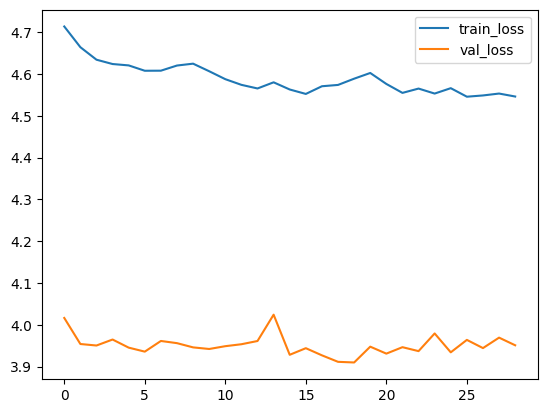

In [49]:
_ = log.plot()

We can get the partial log-likelihood

In [50]:
model.partial_log_likelihood(*val).mean()

-4.9716787

## Prediction

For evaluation we first need to obtain survival estimates for the test set.
This can be done with `model.predict_surv` which returns an array of survival estimates, or with `model.predict_surv_df` which returns the survival estimates as a dataframe.

However, as `CoxPH` is semi-parametric, we first need to get the non-parametric baseline hazard estimates with `compute_baseline_hazards`. 

Note that for large datasets the `sample` argument can be used to estimate the baseline hazard on a subset.

In [51]:
_ = model.compute_baseline_hazards()

In [52]:
surv = model.predict_surv_df(x_test)

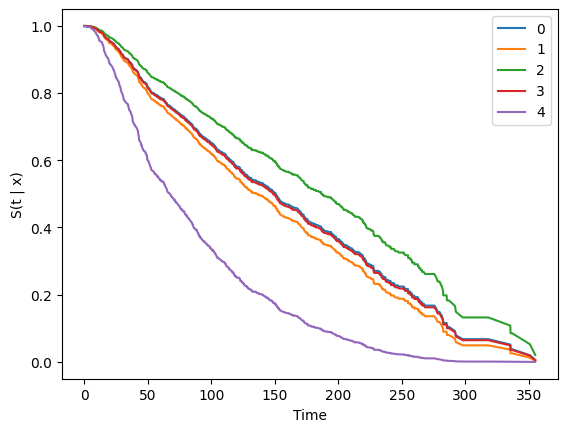

In [53]:
surv.iloc[:, :5].plot()
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

## Evaluation

We can use the `EvalSurv` class for evaluation the concordance, brier score and binomial log-likelihood. Setting `censor_surv='km'` means that we estimate the censoring distribution by Kaplan-Meier on the test set.

In [54]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

In [55]:
ev.concordance_td()

0.6639048991354467

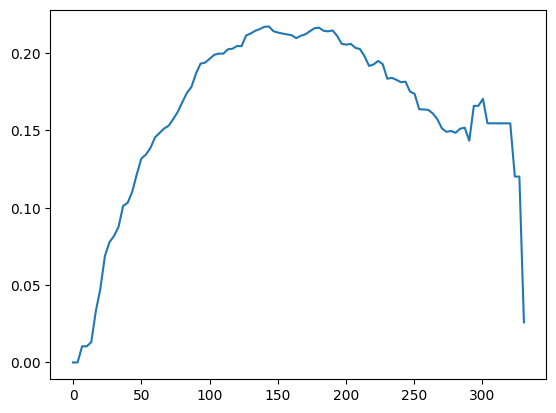

In [56]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
_ = ev.brier_score(time_grid).plot()

In [57]:
ev.integrated_brier_score(time_grid)

0.16330228766081964

In [58]:
ev.integrated_nbll(time_grid)

0.48843843220900046